### PIMA Dataset data analysis

This notebook looks at the PIMA dataset and builds a model to predict the onset of diabetes

Authors:
Thomas Binu tb6405, Chinmay Singh cks9089

### Imports

In [273]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import matplotlib.patches as mpatches
from IPython.display import HTML
from sklearn.feature_selection import SelectKBest, chi2
from operator import itemgetter
import time
import matplotlib as mpl
import time
from fancyimpute import KNN
from matplotlib import cm as cm


import pandas as pd
import numpy as np

%matplotlib inline

mpl.rcParams['figure.figsize'] = (14,14)

### Helper functions

In [242]:
def print_bold(text):
    display(Markdown("**{}**".format(text)))
    
def print_color(text, color='red'):
    display(HTML("<text style=color:{}>{}</text>".format(color, text)))

def plot_correlations(x, y, x_label, y_label):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax1.xcorr(x, y, usevlines=True, maxlags=50, normed=True, lw=2)
    ax1.grid(True)
    ax1.axhline(0, color='black', lw=2)
    
def report_correlations(df):
    
    correlations = df.corr()
    column_names = df.columns.values

    fig, ax = plt.subplots()
    cmap = cm.get_cmap('jet', 30)
 
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)

    fig.colorbar(cax)

    
#     ticks = np.arange(0,len(df),1)
#     ax.set_xticks(ticks)
#     ax.set_yticks(ticks)
    
    ax.set_xticklabels(column_names)
    ax.set_yticklabels(column_names)
    plt.show()

    

def display_confusion_matrix(target_test, target_predict):
    print_bold('Confusion Matrix')
    y_actu = pd.Series(target_test, name='Actual')
    y_pred = pd.Series(target_predict, name='Predicted')
    print(pd.crosstab(y_actu, y_pred))
    
# Basic graph plotting utility
def plot_roc_curve(confusion_matrix_list, models, x_label, y_label, model_names=''):
    
    tpr_fpr_list = []
    
    for idx, cm in enumerate(confusion_matrix_list):
    
        tp = cm[1, 1]
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        
        
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        
        print(models[idx][0], 'TPR:' + str(tpr), 'FPR:' + str(fpr))
    
        
        tpr_fpr_list.append((round(fpr, 2), round(tpr , 2)))
        
    tpr_fpr_list.sort(key=itemgetter(0))
    
    handles = []
    
    for model_name, model, color in models:
        patch = mpatches.Patch(color=color, label=model_name)
        handles.append(patch)
        
    fpr_list, tpr_list = zip(*tpr_fpr_list)
    
    fig, ax = plt.subplots()
    plt.plot(fpr_list, tpr_list, 'bs-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # ax.set_xlim([0,1])
    # ax.set_ylim([0,1])

    for idx, _   in enumerate(tpr_list):
        
        tpr = tpr_list[idx]
        fpr = fpr_list[idx]
        plt.plot([fpr], [tpr], marker='o',  markersize=10, color=models[idx][2])
    plt.legend(handles=handles)
    plt.show()

### Read dataset

In [243]:
DATASET_NAME = 'datasets/diabetes_pima.csv'
COLUMNS = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']
df_original = pd.read_csv(DATASET_NAME)
df_original.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Show statistics of the dataset

In [244]:
df_original.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [245]:
df_original.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [246]:
columns_to_impute = ["Insulin", "Glucose", "BloodPressure", "SkinThickness", "BMI"]
columns = df_original.columns.values

for attr in columns_to_impute:
    df_original[attr].replace(0, np.nan, inplace=True)

x_filled_nn = KNN(k=10).complete(df_original)
df = pd.DataFrame(data=x_filled_nn, columns=columns)

Imputing row 1/768 with 1 missing, elapsed time: 0.094
Imputing row 101/768 with 2 missing, elapsed time: 0.096
Imputing row 201/768 with 1 missing, elapsed time: 0.098
Imputing row 301/768 with 3 missing, elapsed time: 0.100
Imputing row 401/768 with 2 missing, elapsed time: 0.102
Imputing row 501/768 with 0 missing, elapsed time: 0.103
Imputing row 601/768 with 1 missing, elapsed time: 0.105
Imputing row 701/768 with 0 missing, elapsed time: 0.107


### Preprocessing
Replacing missing values with mean of the columns

In [247]:
# imputer = Imputer(missing_values=0, strategy='mean', axis=0)

# columns_to_impute = ["Insulin", "Glucose", "BloodPressure", "SkinThickness", "BMI"]

# for columns in columns_to_impute:
#     df[columns]=imputer.fit_transform(df[[columns]])
    
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.000000,189.320531,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.000000,67.849639,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,26.998228,193.748360,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.000000,168.000000,43.1,2.288,33.0,1.0


### Show the distribution of attributes

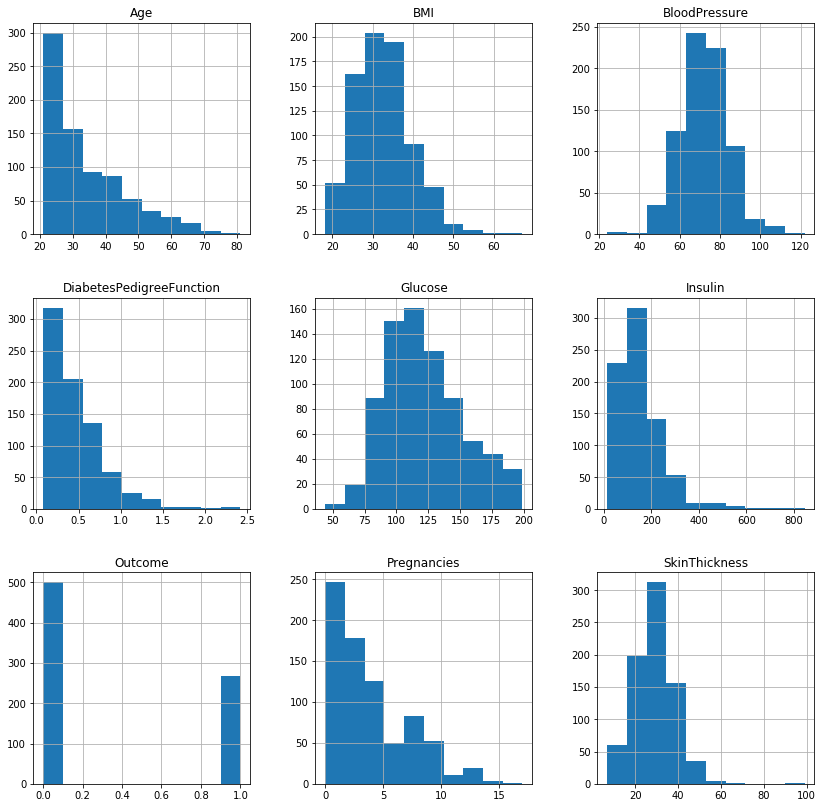

In [248]:
df.hist()
plt.show()

### Show correlation between values

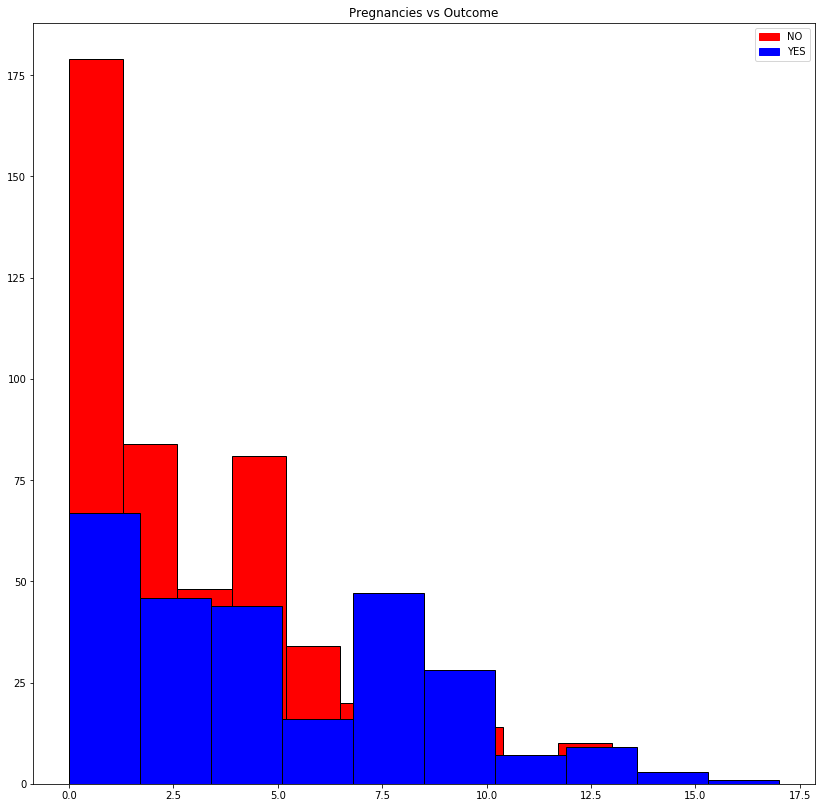

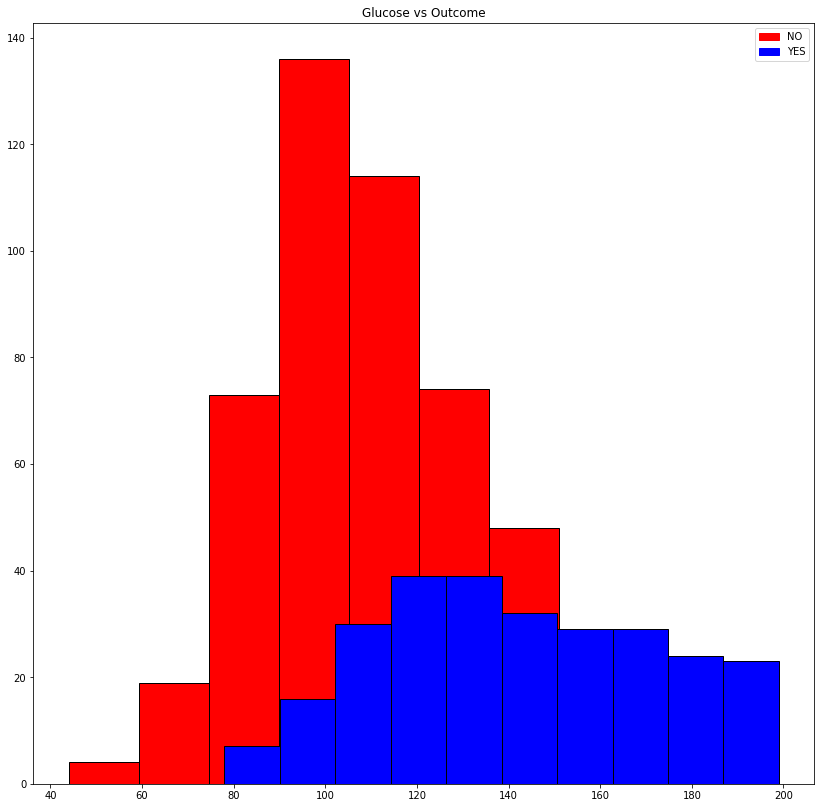

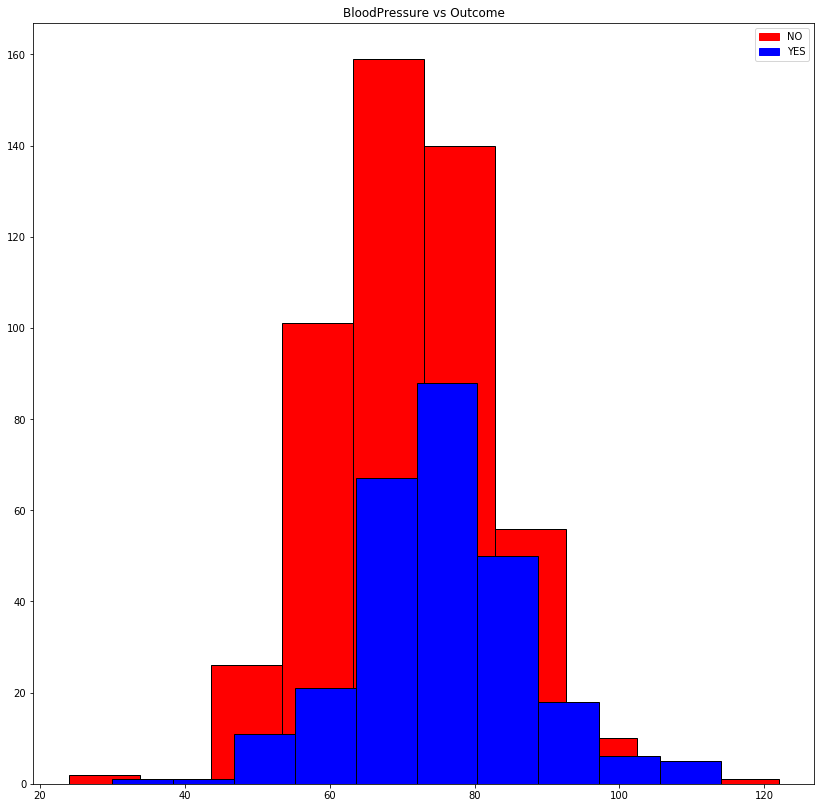

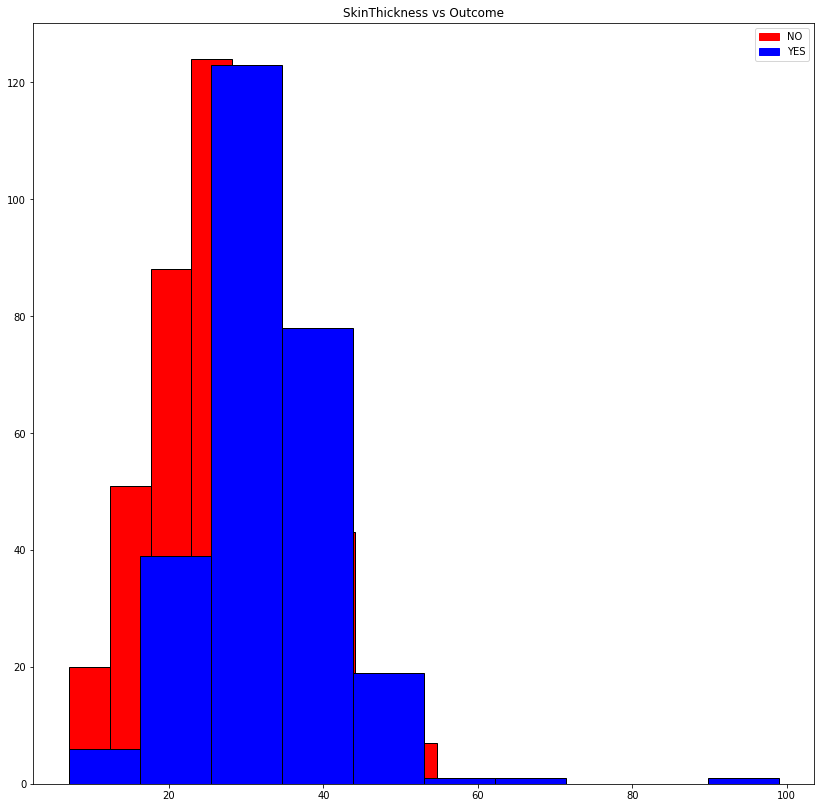

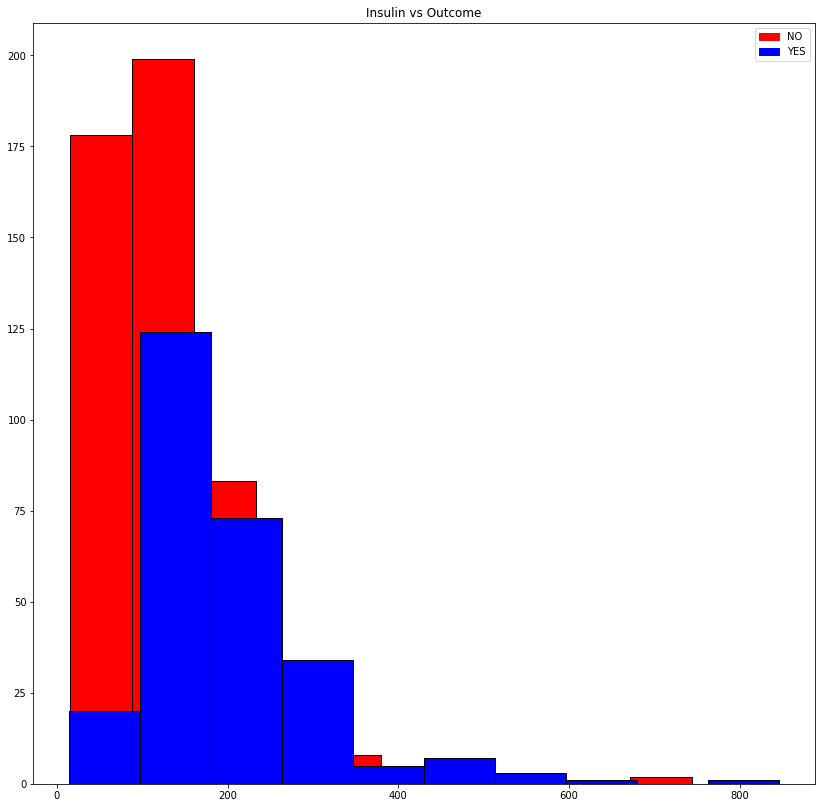

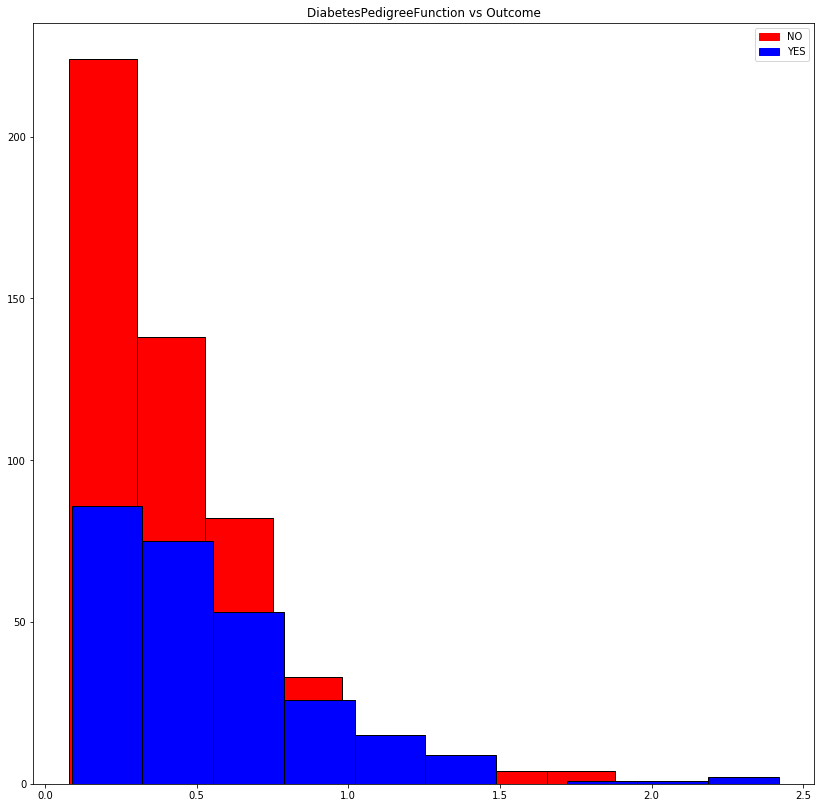

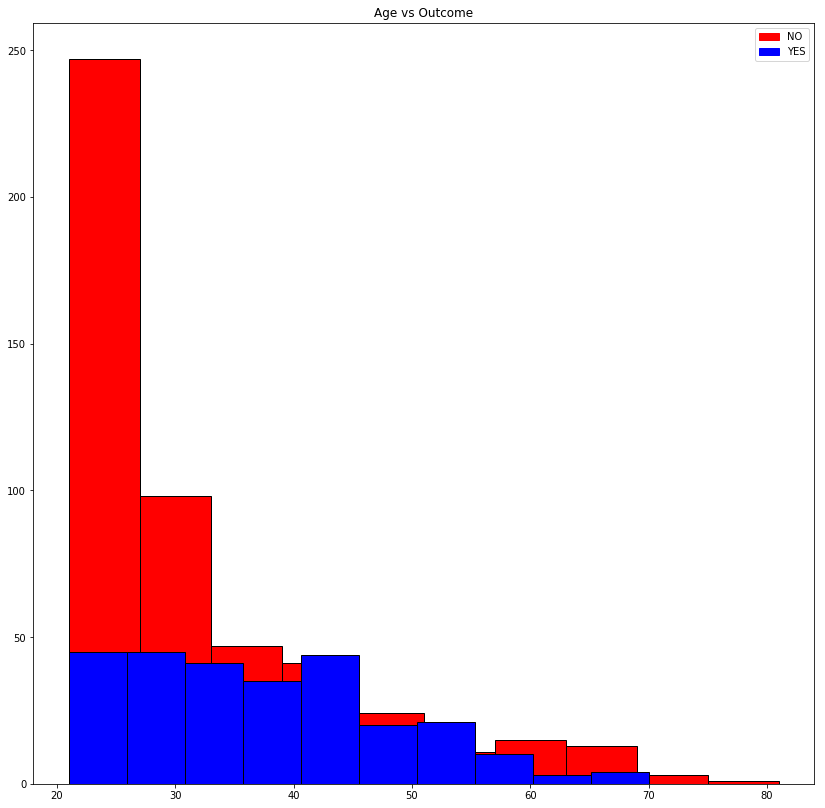

In [249]:
df_gb = df.groupby('Outcome')
gbs = [df_gb.get_group(x) for x in df_gb.groups]
legend_data =[('red', 'NO'), ('blue', 'YES')]

analyze_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']

for idx_outer, col in enumerate(analyze_columns):
    fig = plt.figure()
    title = analyze_columns[idx_outer] + ' vs Outcome'
    
    plt.title(title)
    patches = []
    for idx, gb in enumerate(gbs):

        patches.append(mpatches.Patch(color=legend_data[idx][0], label=legend_data[idx][1]))
        plt.hist(gb[col].values, color=legend_data[idx][0], ec='black')
    plt.legend(handles=patches)
    plt.show()

In [250]:
df_target = df['Outcome']

# Drop the target variable from dataframe
df_attr = df.drop('Outcome' , axis =1)


### Split attribues for training and testing

In [251]:
attr_train, attr_test, target_train, target_test = train_test_split(df_attr , df_target)

### Apply Feature Selection

In [252]:
# attr_train = SelectKBest(score_func=chi2, k=6).fit_transform(attr_train, target_train)
# attr_test = SelectKBest(score_func=chi2, k=6).fit_transform(attr_test, target_test)

### Scaling the values

In [274]:
scaler = StandardScaler(with_mean=False)
scaler.fit(attr_train)
attr_train = scaler.transform(attr_train)
attr_test = scaler.transform(attr_test)

### Models
Fit various models and check results

In [275]:
neural_network = MLPClassifier(hidden_layer_sizes = (3, 3, 3, 2, 2), max_iter=10000)


models = [('Decision Tree', DecisionTreeClassifier(max_depth= 5), 'red'), 
          ('Logistic Regression', LogisticRegression(), 'green'), 
          ('Random Forest', RandomForestClassifier(), 'yellow'),
          ('Naive Bayes', GaussianNB(), 'magenta'),
          ('Adaboost', AdaBoostClassifier(), 'cyan'),
          ('Neural Network', neural_network , 'blue')]

predicted_results = []
time_elapsed = []

for model_names, model, _ in models:
    
    start = time.time()
    
    model.fit(attr_train, target_train)
    
    if isinstance(model, MLPClassifier):
        print(model.classes_)
        
    target_predict = model.predict(attr_test)
    
    end = time.time()
    
    time_elapsed.append(end - start)
    predicted_results.append(target_predict)

[ 0.  1.]


### Results
Show the results of various models

In [277]:
fpr_list = []
tpr_list = []
confusion_matrix_list = []

for idx, (model_name, model, _) in enumerate(models):
    print_color(model_name)
    print_bold('Accuracy Score')
    print(accuracy_score(target_test.values, predicted_results[idx]), end='\n\n')
    
    print_bold('Time taken')
    print(round(time_elapsed[idx], 3) , 'ms')
    
    display_confusion_matrix(target_test.values, predicted_results[idx])
    cm = confusion_matrix(target_test, predicted_results[idx])
    confusion_matrix_list.append(cm)
    
    print_bold('Classification Report')
    print(classification_report(target_test, predicted_results[idx]))

**Accuracy Score**

0.765625



**Time taken**

0.002 ms


**Confusion Matrix**

Predicted  0.0  1.0
Actual             
0.0        120   13
1.0         32   27


**Classification Report**

             precision    recall  f1-score   support

        0.0       0.79      0.90      0.84       133
        1.0       0.68      0.46      0.55        59

avg / total       0.75      0.77      0.75       192



**Accuracy Score**

0.78125



**Time taken**

0.001 ms


**Confusion Matrix**

Predicted  0.0  1.0
Actual             
0.0        118   15
1.0         27   32


**Classification Report**

             precision    recall  f1-score   support

        0.0       0.81      0.89      0.85       133
        1.0       0.68      0.54      0.60        59

avg / total       0.77      0.78      0.77       192



**Accuracy Score**

0.729166666667



**Time taken**

0.027 ms


**Confusion Matrix**

Predicted  0.0  1.0
Actual             
0.0        118   15
1.0         37   22


**Classification Report**

             precision    recall  f1-score   support

        0.0       0.76      0.89      0.82       133
        1.0       0.59      0.37      0.46        59

avg / total       0.71      0.73      0.71       192



**Accuracy Score**

0.744791666667



**Time taken**

0.001 ms


**Confusion Matrix**

Predicted  0.0  1.0
Actual             
0.0        109   24
1.0         25   34


**Classification Report**

             precision    recall  f1-score   support

        0.0       0.81      0.82      0.82       133
        1.0       0.59      0.58      0.58        59

avg / total       0.74      0.74      0.74       192



**Accuracy Score**

0.755208333333



**Time taken**

0.075 ms


**Confusion Matrix**

Predicted  0.0  1.0
Actual             
0.0        113   20
1.0         27   32


**Classification Report**

             precision    recall  f1-score   support

        0.0       0.81      0.85      0.83       133
        1.0       0.62      0.54      0.58        59

avg / total       0.75      0.76      0.75       192



**Accuracy Score**

0.739583333333



**Time taken**

0.748 ms


**Confusion Matrix**

Predicted  0.0  1.0
Actual             
0.0         91   42
1.0          8   51


**Classification Report**

             precision    recall  f1-score   support

        0.0       0.92      0.68      0.78       133
        1.0       0.55      0.86      0.67        59

avg / total       0.81      0.74      0.75       192



### Analysis

Decision Tree TPR:0.457627118644 FPR:0.0977443609023
Logistic Regression TPR:0.542372881356 FPR:0.112781954887
Random Forest TPR:0.372881355932 FPR:0.112781954887
Naive Bayes TPR:0.576271186441 FPR:0.18045112782
Adaboost TPR:0.542372881356 FPR:0.15037593985
Neural Network TPR:0.864406779661 FPR:0.315789473684


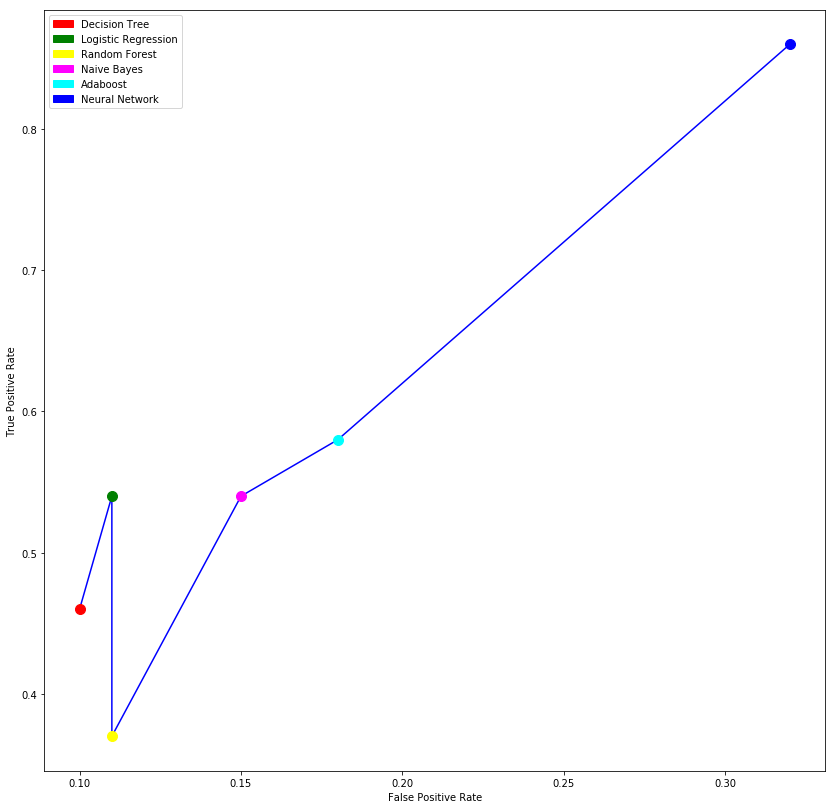

In [278]:
plot_roc_curve(confusion_matrix_list, models, 'False Positive Rate', 'True Positive Rate')